<a href="https://colab.research.google.com/github/abcdise/master_thesis/blob/main/MasterThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from abc import ABC, abstractmethod
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
#@title Class of Itô Diffusions
class ItoDiffusion:

  # ==== Public ==== #

  # Constructor
  def __init__(self, drift_parameter, diffusion_parameter, starting_point, starting_time=0):
    self.drift = drift_parameter
    self.diffusion = diffusion_parameter
    self.__starting_point = starting_point
    self.__starting_time = starting_time

  # Access to private attributes
  def get_starting_point(self):
    return self.__starting_point

  def get_starting_time(self):
    return self.__starting_time

  # Public methods
  def simulate(self, solver):
    solver.generate_paths(self)
    return solver.get_paths()





In [6]:
# @title Euler Maruyama Interface

class EulerMaruyama(ABC):

  # ==== Public ==== #

  # Constructor
  def __init__(self, start_time: float, end_time: float, num_intervals: int, \
               **kwargs):
    self.__start_time = start_time
    self.__end_time = end_time
    self.__num_intervals = num_intervals
    self.__kwargs = kwargs
    self.__num_gaussian_noises = kwargs.get("num_gaussian_noises", 1)
    self.__only_gaussian_noise = kwargs.get("only_gaussian_noise", True)
    self.__num_paths = kwargs.get("num_paths", 10000)
    self.__time_intervals = np.linspace(start_time,
                                       end_time,
                                       num=num_intervals+1)
    self.__diffusion_dimension = kwargs.get("diffusion_dimension", 1)
    self.__paths = np.zeros(shape=(self.__num_paths, self.__num_intervals+1, self.__diffusion_dimension))


  # Set and get private attributes
  def set_start_time(self, start_time):
    self.__start_time = start_time

  def set_end_time(self, end_time):
    self.__end_time = end_time

  def set_num_intervals(self, num_intervals):
    self.__num_intervals = num_intervals

  def set_time_intervals(self, time_intervals):
    self.__time_intervals = time_intervals

  def set_dimension(self, d):
    self.__diffusion_dimension = d

  def get_dimension(self):
    return self.__diffusion_dimension

  def set_num_paths(self, num_paths):
    self.__num_paths = num_paths

  def get_num_intervals(self):
    return self.__num_intervals

  def get_time_intervals(self):
    return self.__time_intervals

  def get_start_time(self):
    return self.__start_time

  def get_end_time(self):
    return self.__end_time

  def get_num_paths(self):
    return self.__num_paths

  def get_paths(self):
    return self.__paths

  def get_num_gaussian_noise(self):
    return self.__num_gaussian_noises

  def get_gaussian_noise(self):
    return self.__noise

  def get_only_gaussian(self):
    return self.__only_gaussian_noise


  # Public methods
  def update_gaussian_noise(self):
    self.__noise = np.random.multivariate_normal(mean=np.zeros(self.__num_gaussian_noises),
                                                 cov=np.eye(self.__num_gaussian_noises),
                                                 size=(self.__num_paths, self.__num_intervals))

    for i in range(self.__num_intervals):
      h = self.__time_intervals[i+1] - self.__time_intervals[i]
      self.__noise[:,i,:] *= np.sqrt(h)

  def generate_paths(self, diffusion, noise=None):
    if noise is None:
      noise = self.__noise
    else:
      for i in range(self.__num_paths):
          self.__paths[i] = self._generate_path(diffusion, self.__noise[i])

  def show_paths(self, path_indices):
    for i in path_indices:
      plt.plot(self.__time_intervals, self.__paths[i])
    plt.show()



  # ==== Private ==== #

  # Private methods

  # Generate a path of the diffusion
  @abstractmethod
  def _generate_path(self, diffusion, noise):
    pass


class EulerMaruyama_DeepBSDE(EulerMaruyama):

  def __init__(self, start_time: float, end_time: float, num_intervals: int, \
               **kwargs):
    super().__init__(start_time=start_time, end_time=end_time, num_intervals=num_intervals,
               **kwargs)
    self.__SDE_dimension = kwargs.get("SDE_dimension", 1)
    self.__SDE_paths = np.zeros(shape=(self.get_num_paths(), self.get_num_intervals(), self.__SDE_dimension))

  def get_SDE_paths(self):
    return self.__SDE_paths

  def _generate_SDE_path(self, diffusion):
    solver = EulerMaruyama_SDE(start_time=self.get_start_time(),
                               end_time=self.get_end_time(),
                               num_intervals=self.get_num_intervals(),
                               diffusion_dimension=self.__SDE_dimension,
                               num_gaussian_noises=self.get_num_gaussian_noise(),
                               num_paths=self.get_num_paths(),
                               only_gaussian_noise=self.get_only_gaussian()
                               )
    self.__SDE_paths = solver.generate_paths(diffusion=diffusion, noise=self.__noise())

  def _generate_path(self, diffusion, noise):
    return 0

solver = EulerMaruyama_DeepBSDE(0, 1, 100, SDE_dimension=1)
paths = solver.get_SDE_paths()
np.shape(paths)






(10000, 100, 1)

In [ ]:
# @title SDE Application

class EulerMaruyama_SDE(EulerMaruyama):
  """
  Class for Euler-Maruyama simulation of SDE

  Parameters:
      start_time (float): The initial time of the simulation.
      end_time (float): The end time of the simulation.
      num_intervals (int): Number of time intervals in the simulation.

  Keyword Arguments:
      diffusion_dimension (int): The dimension of the diffusion process. Default is 1.
      num_gaussian_noises (int): Number of Gaussian noises to simulate. Default is 1.
      num_paths (int): Number of sample paths to simulate. Default is 10000.
      only_gaussian_noise (bool): If True, uses only Gaussian noise in the simulation. Default is True.
  """

  # ==== Public ==== #

  # Constructor
  def __init__(self, start_time: float, end_time: float, num_intervals: int, \
               **kwargs):
    super().__init__(start_time=start_time, end_time=end_time, num_intervals=num_intervals,
                     **kwargs)

  def _generate_path(self, diffusion, noise):
    ret = np.zeros(shape=(self.get_num_intervals()+1, self.get_dimension()))
    # Set the starting point of the diffusion
    x_0 = diffusion.get_starting_point()
    if type(x_0) == float:
      ret[0] = x_0 * np.ones(self.get_dimension())
    else:
      ret[0] = x_0
    # Simulate the following states
    for i in range(1, self.get_num_intervals()+1):
      h = self.get_time_intervals()[i] - self.get_time_intervals()[i-1]
      delta_drift = diffusion.drift(self.get_time_intervals()[i-1], ret[i-1]) * h
      delta_diffusion = np.matmul(diffusion.diffusion(self.get_time_intervals()[i-1], ret[i-1]),
                                  noise[i-1])
      ret[i] = ret[i-1] + delta_drift + delta_diffusion
    return ret

In [34]:
#@title Simulation of Langevin Dynamics: An example
# Langevin Dynamics
b = lambda t, x: np.array([-x])
sigma = lambda t, x: np.array([[np.sqrt(2)]])
diffusion = ItoDiffusion(b, sigma, 0)
solver = EulerMaruyama_SDE(start_time=0, end_time=1, num_intervals=100)
solver.update_gaussian_noise()
solver.generate_paths(diffusion)


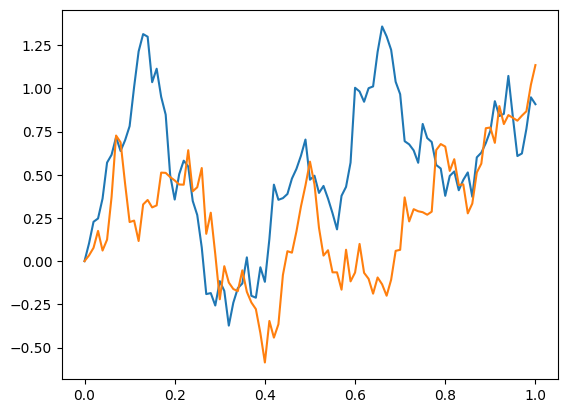

In [35]:
#@title Simulation of Langevin Dynamics: Plot
path_indices = [0,3]
solver.show_paths(path_indices)

TypeError: ignored

#### Playground

Epoch 1/50
4/4 [==============================] - 2s 6ms/step - loss: 0.5011
Epoch 2/50
4/4 [==============================] - 0s 5ms/step - loss: 0.5284
Epoch 3/50
4/4 [==============================] - 0s 6ms/step - loss: 0.5395
Epoch 4/50
4/4 [==============================] - 0s 6ms/step - loss: 0.4340
Epoch 5/50
4/4 [==============================] - 0s 6ms/step - loss: 0.4200
Epoch 6/50
4/4 [==============================] - 0s 6ms/step - loss: 0.3278
Epoch 7/50
4/4 [==============================] - 0s 7ms/step - loss: 0.3036
Epoch 8/50
4/4 [==============================] - 0s 6ms/step - loss: 0.2907
Epoch 9/50
4/4 [==============================] - 0s 5ms/step - loss: 0.2160
Epoch 10/50
4/4 [==============================] - 0s 6ms/step - loss: 0.1789
Epoch 11/50
4/4 [==============================] - 0s 6ms/step - loss: 0.1464
Epoch 12/50
4/4 [==============================] - 0s 6ms/step - loss: 0.1151
Epoch 13/50
4/4 [==============================] - 0s 5ms/step - loss: 0.

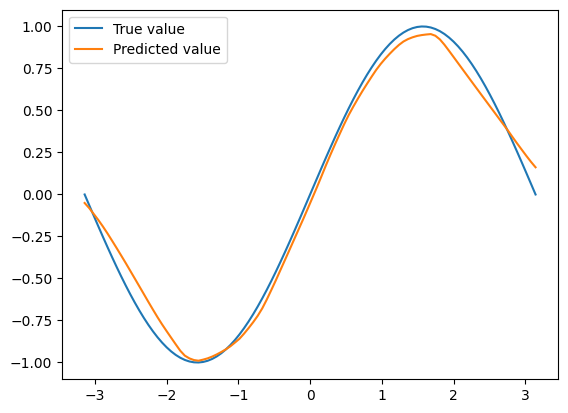

In [45]:
class TensorflowNeuralNetwork:
  def __init__(self, num_hidden_layers, num_neurons_each_layer, \
               input_dim, output_dim):
    self.__num_hidden_layers = num_hidden_layers
    self.__num_neurons_each_layer = num_neurons_each_layer
    self.__input_dim = input_dim
    self.__output_dim = output_dim
    self.__initialize_model()

  def train_model(self, x, y, algorithm='adam'):
    self.__model.compile(optimizer=algorithm,
                         loss='mse')
    self.__model.fit(x, y, epochs=50)

  def get_model(self):
    return self.__model


  def get_output(self, x):
    return 0

  # ===== Private methods ===== #
  def __initialize_model(self):
    inputs = keras.Input((self.__input_dim,), name='inputs_layer')
    x = keras.layers.Dense(self.__num_neurons_each_layer,
                           activation='sigmoid',
                           name='hidden_layer_1')(inputs)
    for i in range(self.__num_hidden_layers-1):
      x = keras.layers.Dense(self.__num_neurons_each_layer,
                             activation='relu',
                             name=f'hidden_layer_{i+2}')(x)
    outputs = keras.layers.Dense(1,
                                 activation='linear',
                                 name='outputs_layer')(x)
    self.__model = keras.Model(inputs=inputs, outputs=outputs, name='neural_network_model')


x = np.linspace(-np.pi, np.pi, 100)
y = np.sin(x)
estimator = TensorflowNeuralNetwork(5, 256, 1, 1)
estimator.train_model(x, y)
model = estimator.get_model()
y_hat = model.predict(x)
plt.plot(x, y, label='True value')
plt.plot(x, y_hat, label='Predicted value')
plt.legend()
plt.show()